# TimesNet Tutorial for Anomaly Detection
This notebook demonstrates how to use TimesNet for time series anomaly detection

## 1. Packages import and prepare arguments

In [2]:
import os
import time

import numpy as np
import torch.cuda
from sklearn.metrics import precision_recall_fscore_support

from tsadlib import ConfigType
from tsadlib import EarlyStopping
from tsadlib import TimesNet
from tsadlib import data_provider
from tsadlib.utils.adjustment import point_adjustment
from tsadlib.utils.constants import PROJECT_ROOT

# Set up device for computation (CUDA GPU, Apple M1/M2 GPU, or CPU)
if torch.cuda.is_available():
    device = 'cuda:1'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'use device: {device}')
device = torch.device(device)

# Define paths for dataset and model checkpoints
# DATASET_ROOT = 'E:\\liuzhenzhou\\datasets'
DATASET_ROOT = '/Users/liuzhenzhou/Documents/backup/datasets/anomaly_detection/npy'
DATASET_TYPE = 'MSL'  # Mars Science Laboratory dataset
CHECKPOINTS = os.path.join(PROJECT_ROOT, 'checkpoints')

# Configure TimesNet hyperparameters and training settings
args = ConfigType(**{
    'root_path': os.path.join(DATASET_ROOT, DATASET_TYPE),
    'dataset': DATASET_TYPE,
    'seq_len': 100,  # Length of input sequence
    'batch_size': 128,  # Number of samples per batch
    'num_workers': 10,  # Number of data loading workers
    'top_k': 3,  # Top k time-frequency combinations
    'd_model': 8,  # Dimension of model
    'd_ff': 16,  # Dimension of feed-forward network
    'num_kernels': 6,  # Number of inception kernels
    'e_layers': 1,  # Number of encoder layers
    'enc_in': 55,  # Input dimension
    'c_out': 55,  # Output dimension
    'dropout': 0.1,  # Dropout rate
    'embed_type': 'timeF',  # Time feature embedding type
    'freq': 'h',  # Frequency of the time series (hourly)
    'anomaly_ratio': 1,  # Ratio of anomaly samples
    'train_epochs': 1,  # Number of training epochs
    'learning_rate': 0.0001  # Learning rate for optimization
})

# Load training and testing data
train_data, train_loader = data_provider(args, flag='train')
test_data, test_loader = data_provider(args, flag='test')

use device: mps
2025-03-19 21:30:22.942 | INFO     | tsadlib.data_provider.datasets.msl:__init__:71 - test set's shape: (73729, 55)
2025-03-19 21:30:22.942 | INFO     | tsadlib.data_provider.datasets.msl:__init__:72 - train set's shape: (58317, 55)
2025-03-19 21:30:22.977 | INFO     | tsadlib.data_provider.datasets.msl:__init__:71 - test set's shape: (73729, 55)
2025-03-19 21:30:22.977 | INFO     | tsadlib.data_provider.datasets.msl:__init__:72 - train set's shape: (58317, 55)


## 2. Model definition and training

In [3]:
# Initialize model and training components
model = TimesNet(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = torch.nn.MSELoss()
early_stopping = EarlyStopping(patience=args.patience)
train_steps = len(train_loader)
time_now = time.time()

# Training loop
for epoch in range(1):
    model.train()
    train_loss = []
    iter_count = 0
    epoch_time = time.time()

    for i, (batch_x, batch_y) in enumerate(train_loader):
        iter_count += 1
        optimizer.zero_grad()
        batch_x = batch_x.float().to(device)

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_x)

        if (i + 1) % 100 == 0:
            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((args.train_epochs - epoch) * train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        # Backward pass
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(train_loss)

    # Early stopping check
    if early_stopping(np.mean(train_loss), model, os.path.join(PROJECT_ROOT, 'checkpoints'), 'MSL'):
        print("Early stopping triggered")
        break

	iters: 100, epoch: 1 | loss: 0.7604038
	speed: 0.3471s/iter; left time: 123.5692s
	iters: 200, epoch: 1 | loss: 0.4496965
	speed: 0.1448s/iter; left time: 37.0810s
	iters: 300, epoch: 1 | loss: 0.5242749
	speed: 0.1457s/iter; left time: 22.7369s
	iters: 400, epoch: 1 | loss: 0.6750700
	speed: 0.1449s/iter; left time: 8.1119s
Epoch: 1 cost time: 137.83555817604065


## 3. Model Evaluation

In [4]:
from torch import nn

# Set model to evaluation mode and initialize score containers
model.eval()
train_scores = []
test_scores = []
test_labels = []
anomaly_criterion = nn.MSELoss(reduction='none')

# Calculate reconstruction scores for training data
with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.float().to(device)
        # reconstruction
        outputs = model(batch_x)
        # criterion
        score = torch.mean(anomaly_criterion(batch_x, outputs), dim=-1)
        score = score.detach().cpu().numpy()
        train_scores.append(score)

train_scores = np.concatenate(train_scores, axis=0).reshape(-1)

# Calculate reconstruction scores for test data
for batch_x, batch_y in test_loader:
    batch_x = batch_x.float().to(device)
    outputs = model(batch_x)

    # Calculate reconstruction error as anomaly score
    score = torch.mean(anomaly_criterion(outputs, batch_x), dim=-1)
    test_scores.append(score.detach().cpu().numpy())
    test_labels.append(batch_y)

# Combine scores and labels from all batches
test_scores = np.concatenate(test_scores, axis=0).reshape(-1)  # [total_samples, seq_len]
test_labels = np.concatenate(test_labels, axis=0).reshape(-1)  # [total_samples, seq_len]

# Calculate threshold using combined scores from both training and test sets
combined_scores = np.concatenate([train_scores, test_scores], axis=0)
from tsadlib import threshold

final_threshold = threshold.percentile_threshold(combined_scores, 99)

# Generate predictions based on threshold
pred_labels = (test_scores > final_threshold).astype(int)

gt, pred = point_adjustment(test_labels, pred_labels)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(gt, pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.8924
Recall: 0.7299
F1-score: 0.8030


## 4. 可视化结果

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

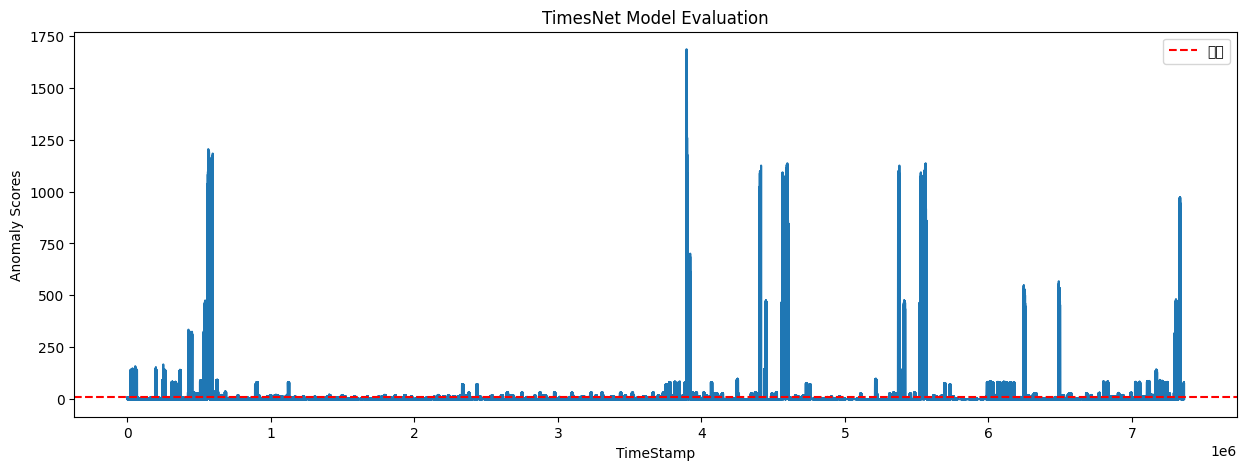

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(test_scores)
plt.axhline(y=final_threshold, color='r', linestyle='--', label='阈值')
plt.title('TimesNet Model Evaluation')
plt.xlabel('TimeStamp')
plt.ylabel('Anomaly Scores')
plt.legend()